# Image reconstruction with Cartesian SENSE

In this tutoral we will read in a 2D cine dataset from ocmr  (2D+time).
This data is a Cartesian bSSFP cine which has been aquired with Partial Fourier acqustion in the kx (readout) direction.
We will reconstruct a fully sampled k-space using TensorFlowMRI, and then simulate SENSE undersampling

We will then take this undersampled k-space and reconstreuct using SENSE in TensorFlow MRI

## Set up TensorFlow MRI
If you have not yet installed TensorFlow MRI in your environment, you may do so
now using `pip`: 

In [37]:
%pip install --quiet tensorflow-mri
# Upgrade Matplotlib. Versions older than 3.5.x may cause an error below.
%pip install --quiet --upgrade matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Then, import the package into your program to get started:

In [38]:
import tensorflow_mri as tfmri
print("TensorFlow MRI version:", tfmri.__version__)

TensorFlow MRI version: 0.22.0


We will also need a few additional packages:

In [39]:
from glob import glob
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

%pip  install -U matplotlib
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.8/dist-packages (3.7.5)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Using a GPU

TensorFlow MRI supports CPU and GPU computation. If there is a GPU available in
your environment and it is visible to TensorFlow, it will be used automatically.

:::{tip}
In Google Colab, you can enable GPU computation by clicking on
**Runtime > Change runtime type** and selecting **GPU** under
**Hardware accelerator**.
:::

:::{tip}
You can control whether CPU or GPU is used for a particular operation via
the [`tf.device`](https://www.tensorflow.org/api_docs/python/tf/device)
context manager.
:::

## Prepare the data
We will be using an example brain dataset from the
[ISMRM Reproducibility Challenge 1](https://ismrm.github.io/rrsg/challenge_one/).
Let's download it.

In [40]:
cardiac_cine_data_filename = 'fs_0005_1_5T.h5'
cardiac_cine_data_url = "https://ocmr.s3.us-east-2.amazonaws.com/data/fs_0005_1_5T.h5."
!wget --quiet -O {cardiac_cine_data_filename} {cardiac_cine_data_url}

/bin/bash: wget: command not found


You may need to install 'ismrmrd-python' and 'ismrmrd-python-tools'. This can be done like this:

Install ismrmrd-python from here: https://github.com/ismrmrd/ismrmrd-python

    %%bash
    if [ $(pip list --disable-pip-version-check | grep -c -w 'ismrmrd ') == 0 ]
    then
        git clone https://github.com/ismrmrd/ismrmrd-python.git /var/tmp/ismrmrd-python
        python -m pip install --disable-pip-version-check -r /var/tmp/ismrmrd-python/requirements.txt
        python -m pip install --disable-pip-version-check /var/tmp/ismrmrd-python
        rm -rf /var/tmp/ismrmrd-python
    fi
    pip list --disable-pip-version-check | grep -w 'ismrmrd '

Install ocmr reader from here: https://raw.githubusercontent.com/MRIOSU/OCMR/master/Python/read_ocmr.py

    %%bash
    wget https://raw.githubusercontent.com/MRIOSU/OCMR/master/Python/read_ocmr.py

This dataset contains a fully sampled cartesian dataset. from the OCMR dataset:
https://github.com/MRIOSU/OCMR/blob/master/Python/example_ocmr.ipynb
The data is stored
in a HDF5 file, which we can read using [h5py](https://www.h5py.org/). The
downloaded file also has the sampling locations or *k*-space trajectory, so we
do not need to calculate it.

In [41]:
# read_ocmr is downloaded from here:
# https://raw.githubusercontent.com/MRIOSU/OCMR/master/Python/read_ocmr.py

import read_ocmr as read

kData,param = read.read_ocmr(cardiac_cine_data_filename)
print('Dimension of kData: ', kData.shape)

kData = np.squeeze(kData)
print('Dimension of kData: ', kData.shape)
# kx, ky, ch, phase

# Reverse the order of the dimensions.
# [kx, ky, ch, phase] -> [phase, ch, kx, ky ]
kspace = np.transpose(kData, [3,2,0,1])
print(kspace.shape)
#(18, 18, 512, 208)
#[phase, ch, kx, ky ]


Imaging acquisition starts acq  0
Dimension of kData:  (512, 208, 1, 18, 18, 1, 1, 1, 1)
Dimension of kData:  (512, 208, 18, 18)
(18, 18, 512, 208)


Lets view the k-space data

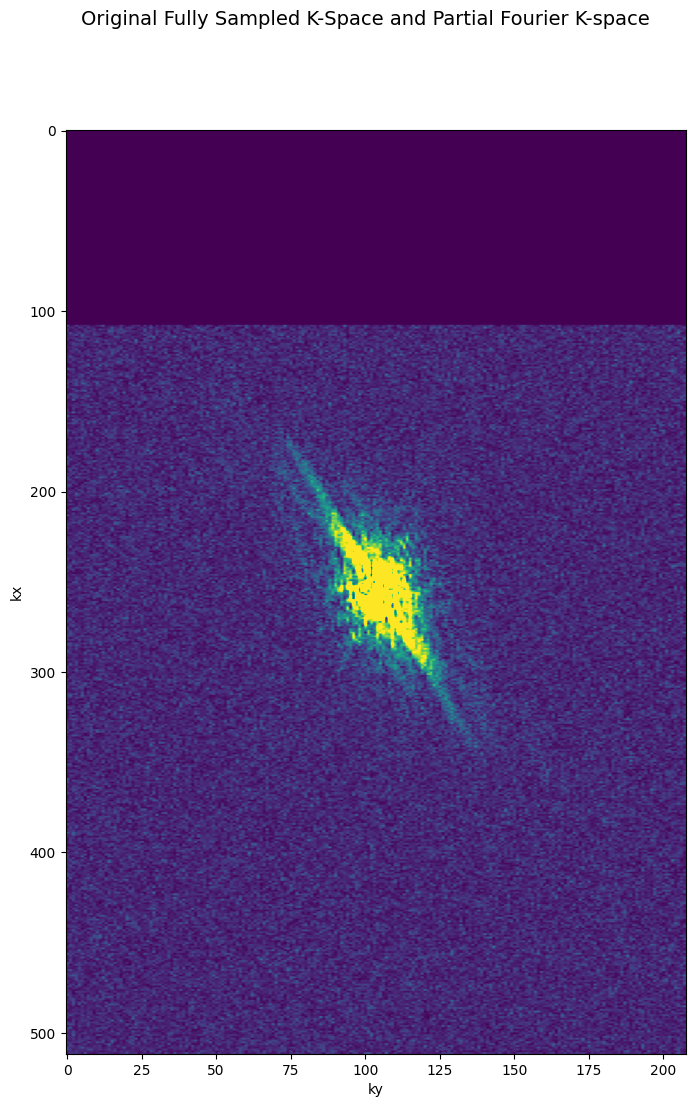

In [42]:
fig1 = plt.figure(1, figsize=(8, 12)); fig1.suptitle("Original Fully Sampled K-Space and Partial Fourier K-space", fontsize=14);
tmp = plt.imshow(np.abs(np.squeeze(kspace[0,0,:,:])), aspect= 'auto');
plt.xlabel('ky');plt.ylabel('kx'); tmp.set_clim(0.0,0.01*np.max(np.abs(kspace))) # ky by kx

You can see that this k-space was acquired with Partial Foutier in the readout, kx, direction (only 404 of the 512 data points are acquired)
We will reconstruct this using the code from the Partial Fourier Tutorial to get a fully sampled k-space

In [44]:
# The tensorflow functions for Partial Fourier Reconstruction takes in only the k-space which was acquired
# kspace should only contain the observed data, without zero-filling of any kind.

# Therefore in this case we need to remove all phase encode lines which are all zeros

# Find rows that contain only zeros
kspace_PF = kspace[:, :, np.any(kspace != 0, axis=(0, 1, 3)),:]
print('kspace_PF.shape: ', kspace_PF.shape)
# (18, 18, 404, 208)

# The tensowflow function needs to know what proportion if k-space was acquired
partial_fourier_factor = kspace_PF.shape[2] / kspace.shape[2]
print('partial_fourier_factor: ', partial_fourier_factor)
# 0.7890625
kspace_PF_flipped = np.flip(kspace_PF, axis=-2)

# Now do a partial fourier reconstruction seperately each time point seperately
# tfmri can do all time point together but it is less likey to run out of memory if we process one time point at a time
Reconstructed_Image = []
for t in range(np.shape(kspace_PF_flipped)[0]):
    kspace_PF_single_phase = np.squeeze(kspace_PF_flipped[t,:,:,:])
    #print('kspace_PF_single_phase.shape: ', kspace_PF_single_phase.shape)
    #(18, 404, 208)

    recon_im = tfmri.recon.partial_fourier(
            kspace_PF_single_phase, [partial_fourier_factor, 1.0], method="pocs",
            preserve_phase=True)
    
    recon_im = np.flip(recon_im, axis=-2)
    Reconstructed_Image.append(recon_im)

final_cine_img = np.array(Reconstructed_Image)
fully_sampled_kspace = tfmri.signal.fft(final_cine_img, axes=[-2, -1], norm='ortho', shift=True)


kspace_PF.shape:  (18, 18, 404, 208)
partial_fourier_factor:  0.7890625


(18, 18, 512, 104)


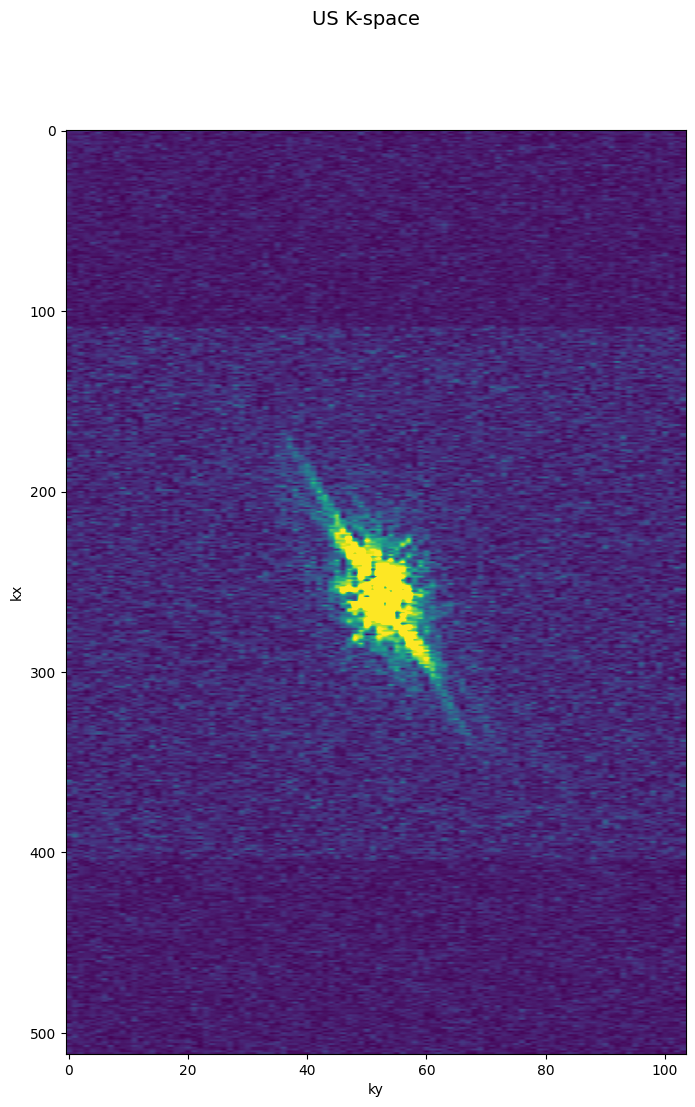

In [45]:
# Here simulate the 2x undersampling (by removing every other line of k-space)

kspace_US = fully_sampled_kspace[:,:,:,::2]
print(np.shape(kspace_US))
#(18, 18, 512, 104)
#[phase, ch, kx, ky ]

fig1 = plt.figure(1, figsize=(8, 12)); fig1.suptitle("US K-space", fontsize=14)
tmp = plt.imshow(np.abs(np.squeeze(kspace_US[0,0,:,:])), aspect= 'auto')
plt.xlabel('ky');plt.ylabel('kx'); tmp.set_clim(0.0,0.01*np.max(np.abs(kspace_US))) # ky by kx


## Compute coil sensitivity maps

The zero-filled image has visible artefact because the *k*-space sampling rate
is below the Nyquist rate. Information from multiple coils can be used more
effectively to address this problem, by performing a SENSE reconstruction.

First we need to obtain the coil sensitivity maps. These can be estimated from
the individual coil images. A low-resolution estimate of the images is suitable
for this purpose and is easy to obtain, assuming the central part of
*k*-space is sufficiently sampled.

To obtain the low resolution image estimates, we will first apply a low-pass
filter to the *k*-space data. We will be using
[`tfmri.signal.hann`](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/signal/hann) and
[`tfmri.signal.filter_kspace`](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/signal/filter_kspace).

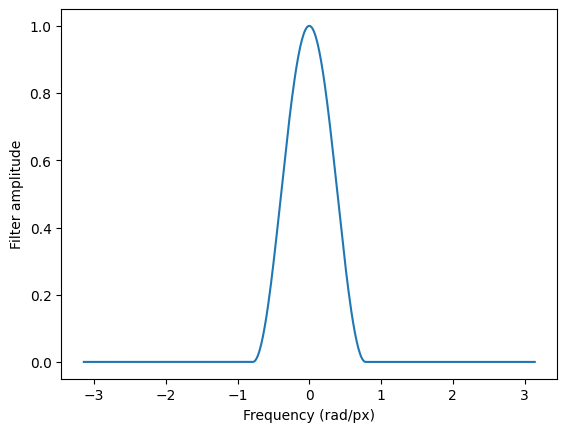

In [46]:
# First let's filter the *k*-space data with a Hann window. We will apply the
# window to the central 25% of k-space (determined by the factor 4 below), the
# remaining 80% is filtered out completely.
filter_fn = lambda x: tfmri.signal.hann(4 * x)

# Let's plot the effect of our filter.
x = tf.linspace(-np.pi, np.pi, 512)
plt.plot(x, filter_fn(x))
plt.xlabel('Frequency (rad/px)')
plt.ylabel('Filter amplitude')

#[phase, ch, kx, ky ]
# Finally, apply the filter to the k-space data.
data = np.squeeze(kspace[0,:,:,:])

filtered_kspace = tfmri.signal.filter_kspace( data,
                                             filter_rank = 2,
                                             filter_fn=filter_fn)

(18, 512, 208)


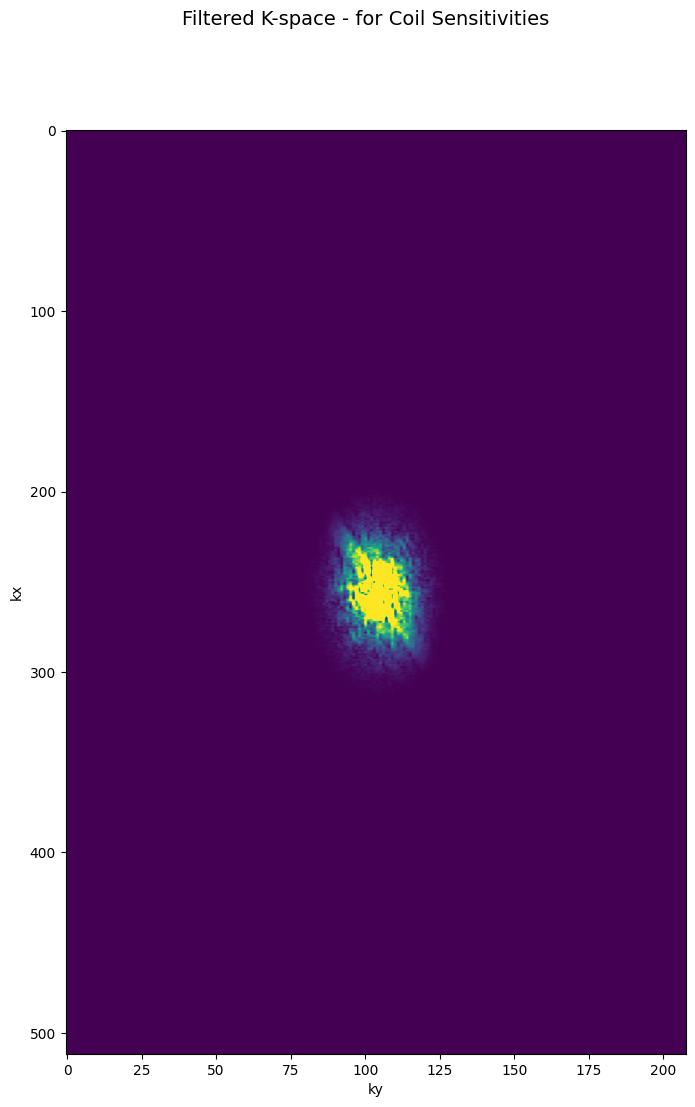

In [47]:
print(filtered_kspace.shape)
#(18, 512, 208)

fig1 = plt.figure(1, figsize=(8, 12)); fig1.suptitle("Filtered K-space - for Coil Sensitivities", fontsize=14)
tmp = plt.imshow(np.abs(np.squeeze(filtered_kspace[0,:,:])), aspect= 'auto')
plt.xlabel('ky');plt.ylabel('kx'); tmp.set_clim(0.0,0.01*np.max(np.abs(filtered_kspace))) # ky by kx


We can now reconstruct the images from the filtered *k*-space data as
described in [Perform zero-filled reconstruction](#perform-zero-filled-reconstruction).

(18, 512, 208)


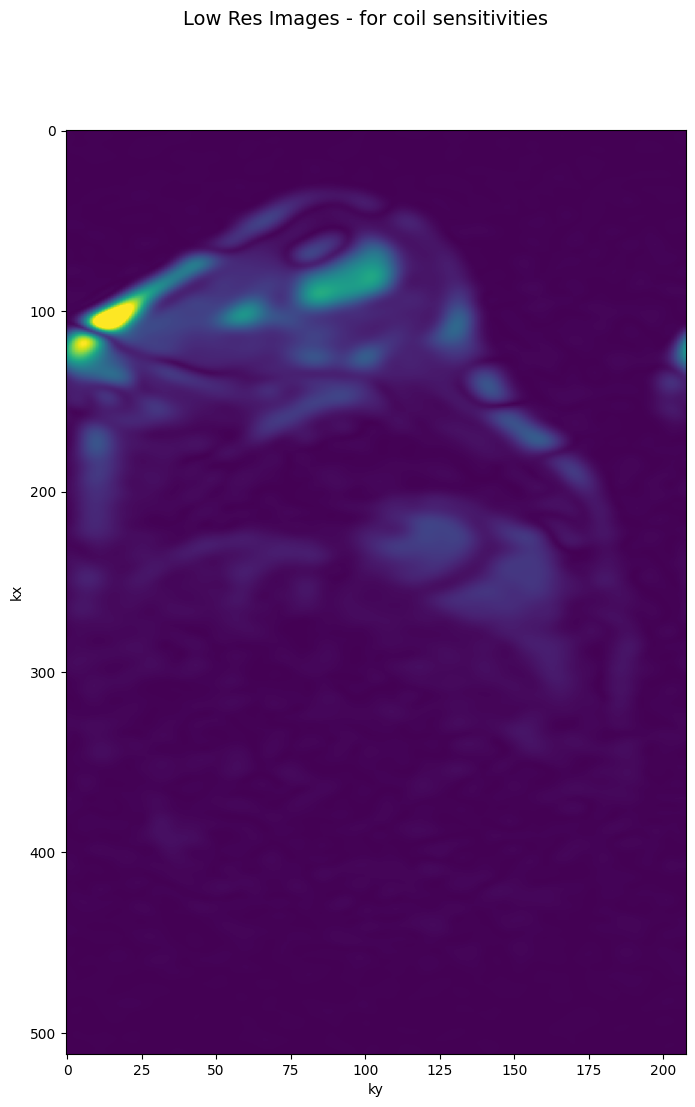

In [48]:
low_res_images = tfmri.recon.adjoint(filtered_kspace,
                                     image_shape=[512, 208])
print(low_res_images.shape)

fig1 = plt.figure(1, figsize=(8, 12)); fig1.suptitle("Low Res Images - for coil sensitivities", fontsize=14)
tmp = plt.imshow(np.abs(np.squeeze(low_res_images[0,:,:])), aspect= 'auto')
plt.xlabel('ky');plt.ylabel('kx'); tmp.set_clim(0.0,0.1*np.max(np.abs(low_res_images))) # ky by kx

Let's now use these images to obtain the coil sensitivity maps. We will use
Walsh's method, one of the methods implemented in
[tfmri.coils.estimate_sensitivities](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/coils/estimate_sensitivities).

(18, 512, 208)


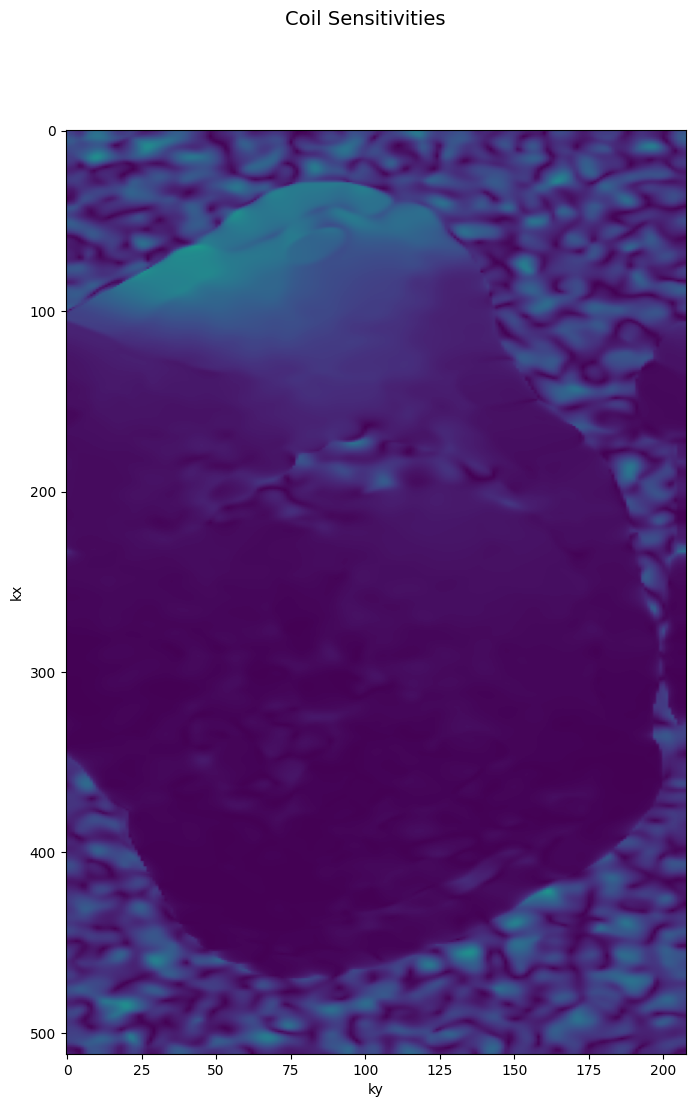

In [49]:
sensitivities = tfmri.coils.estimate_sensitivities(
    low_res_images, coil_axis=0, method='walsh')

print(sensitivities.shape)

fig1 = plt.figure(1, figsize=(8, 12)); fig1.suptitle("Coil Sensitivities", fontsize=14)
tmp = plt.imshow(np.abs(np.squeeze(sensitivities[0,:,:])), aspect= 'auto')
plt.xlabel('ky');plt.ylabel('kx'); tmp.set_clim(0.0,np.max(np.abs(sensitivities))) # ky by kx

In [62]:
# Although tfmri.recon.sense supports batches, it is quite likely to run out
# of memory. Therefore we perform SENSE one phase at a time.

Final_cine = []
for t in range (np.shape(kspace_US)[0]) :

  #sense(kspace, sensitivities, reduction_axis, reduction_factor, rank=None, l2_regularizer=0.0, fast=True)[source]
  SENSEreconstructedImage =  tfmri.recon.sense((np.squeeze(kspace_US[t,:,:,:])).astype(np.complex64), sensitivities, reduction_axis = [-1], reduction_factor=[2])
  
  Final_cine.append(SENSEreconstructedImage)

final_cine = np.array(Reconstructed_Image)


In [65]:
print(final_cine.shape)
#remove RO oversampling
ROsize = final_cine.shape[2]

final_cine = final_cine[:,:,int(ROsize/4):int(3*ROsize/4),:]
print(final_cine.shape)
 #[ph, x, y ]
 #(18, 256, 208)

(18, 18, 512, 208)
(18, 18, 256, 208)


In [66]:
# now do coil combination
coil_combined_cine = tfmri.coils.combine_coils(final_cine, maps=None, coil_axis= 1)
print(coil_combined_cine.shape)
# 18, 256, 256

(18, 256, 208)


Finally lets see the final SENSE reconstructed image

In [67]:
import matplotlib.animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

nFrames = len(Reconstructed_Image)

t= np.linspace(0,len(Reconstructed_Image))
def animate(t):
    plt.imshow(np.squeeze(tf.math.abs(coil_combined_cine[t,:,:])), cmap = 'gray')
    plt.title('Image')

matplotlib.animation.FuncAnimation(fig, animate, frames=nFrames)

## Conclusion
Congratulations! You performed a SENSE reconstruction using
TensorFlow MRI. The code used in this notebook works for higher amounts of SENSE.
 It also works for 3D imaging. Feel free to try with your own data!

For more information about the functions used in this tutorial, check out the
[API documentation](https://mrphys.github.io/tensorflow-mri/api_docs/). For
more examples of using TensorFlow MRI, check out the
[tutorials](https://mrphys.github.io/tensorflow-mri/tutorials/).

### Let us know!
Please tell us what you think about this tutorial and about TensorFlow MRI.
We would like to hear what you liked and how we can improve. You will find us
on [GitHub](https://github.com/mrphys/tensorflow-mri/issues/new).

In [53]:
# Copyright 2022 University College London. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.